In [ ]:
#imports
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support, accuracy_score
import numpy as np
from sklearn.utils import shuffle
import imgaug as ia
!pip install memory_profiler
from memory_profiler import memory_usage
import time
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
import seaborn as sns
import pandas as pd
import joblib
import matplotlib.pylab as pylab

In [ ]:
#local imports
from data_preprocessing import get_dataset
from utility import get_metrics, auc_roc_curves

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Increase size of plot labels
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

## Get CNN Data

In [ ]:
class LiverCNN(nn.Module):
    def __init__(self, imgsize, return_attention=True):
      super(LiverCNN, self).__init__()

      # convolutional layers
      self.conv1 = nn.Conv2d(1, 12, kernel_size=3, padding=1)
      self.conv2 = nn.Conv2d(12, 24, kernel_size=3, padding=1)

      # pool fetaures together
      self.pool = nn.MaxPool2d(2, 2)

      # use dropout layer to delete 30% of features to prevent overfitting
      self.drop = nn.Dropout2d(p=0.3)

      # define attention layer
      self.return_attention = return_attention

      self.attention = nn.Sequential(
          nn.Conv2d(24, 1, kernel_size=1),  # attention mechanism applied to feature maps
          nn.Sigmoid()
      )

      # define fully connected layer for output
      # image is pooled twice with 2x2 kernel -> = imgsize/4 x imgsize/4 image
      # convolution layer generates 24 patches, so x 24
      self.out_layer_size = int(imgsize/4 * imgsize/4 * 24)
      self.fc1 = nn.Linear(self.out_layer_size, imgsize)
      self.fc2 = nn.Linear(imgsize, 2)

    def forward(self, x):

      # apply comvolutional layers with relu and pooling
      x = F.relu(self.pool(self.conv1(x)))
      x = F.relu(self.pool(self.conv2(x)))

      # attention mechanism
      attention_weights = self.attention(x)
      x = x * attention_weights  # apply attention to feature maps

      # drop training data to prevent overfitting
      x = F.dropout(self.drop(x), training=self.training)

      # flatten to prepare for fully connected layers
      x = x.reshape(-1, self.out_layer_size)

      # fully connected layers (the first with relu)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)

      if self.return_attention:
          return x, attention_weights
      else:
          return x

In [ ]:
def get_cnn_data(x_test_a, y_test_a):
    # Note: must use CUDA to load these
    imgsize=128

    # Original + Augmented Data
    model_a = LiverCNN(imgsize=imgsize).to(device)
    model_a.load_state_dict(torch.load(base_path+'cnn_model_original_plus_augmented_data.pth'))
    accuracy_a, runtime_a, peak_mem_a, test_outputs_a, y_pred_a, f1_a = get_metrics(x_test_a, y_test_a, model_a)
    y_probs_a = torch.nn.functional.softmax(test_outputs_a[0].cpu(), dim=1).detach().numpy()[:, 1]

    # Combine Outputs
    cnn_auc_roc = [y_probs_a, y_test_a.cpu().numpy(), 'orange']
    cnn_heatmap = [accuracy_a, runtime_a/test_outputs_a[0].size(0)]

    return cnn_auc_roc, cnn_heatmap

## Get SVM Data

In [ ]:
def get_svm(x_test_a, y_test_a):

  # no external, yes data augmentation
  svm_model = joblib.load(base_path+'svm_01.pkl')
  scaler = joblib.load(base_path+'scaler_01.pkl')
  pca = joblib.load(base_path+'pca_01.pkl')

  def flatten(x):
    return x.reshape(x.shape[0], -1)

  x = flatten(x_test_a)

  x = scaler.transform(x)
  x = pca.transform(x)

  runtime, peak_mem, y_pred = get_memory_usage_and_runtime(svm_model.predict, (x,))

  accuracy = accuracy_score(y_test_a, y_pred)

  y_probs = svm_model.predict_proba(x)[:, 1]

  svm_auc_roc = [y_probs, y_test_a, "purple"]
  svm_heatmap = [accuracy, runtime/y_test_a.shape[0]]


  return svm_auc_roc, svm_heatmap

## Get Pretrained Data

In [ ]:
def get_pretrained_model(n_classes=2):
  # Alexnet
  model = models.alexnet(pretrained=True)

  # freeze early layers
  for param in model.parameters():
    param.requires_grad = False

  # change first layer to accept grayscale
  model.features[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

  # custom classifier
  n_inputs = model.classifier[6].in_features
  model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

  return model

In [ ]:
def get_pretrained(x_test_a, y_test_a):
  # Note: must use CUDA to load these
  imgsize=128

  # Original + Augmented Data
  model_a = get_pretrained_model().to(device)
  model_a.load_state_dict(torch.load(base_path+'alexnet_original_plus_augmented_data.pth'))
  accuracy_a, runtime_a, peak_mem_a, test_outputs_a, y_pred_a, f1_a = get_metrics(x_test_a, y_test_a, model_a)
  y_probs_a = torch.nn.functional.softmax(test_outputs_a.cpu(), dim=1).detach().numpy()[:, 1]

  # Combine Outputs
  pretrained_auc_roc = [y_probs_a, y_test_a.cpu().numpy(), 'green']
  pretrained_heatmap = [accuracy_a, runtime_a/test_outputs_a[0].size(0)]

  return pretrained_auc_roc, pretrained_heatmap

## Get All Data

In [ ]:
data_path = './data/all_data.npz' # all_data.npz path
base_path = './models' # where the models are stored

In [ ]:
def load_models():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ------- Get test data -----
    print("Loading Data ...")
    # Original Data + Augmented Data to Train
    x_train_a, x_val_a, x_test_a, y_train_a, y_val_a, y_test_a = get_dataset(use_external=False, aug_data=True)

    # convert to tensors
    x_test_a_t = torch.tensor(x_test_a, dtype=torch.float32).unsqueeze(1).to(device)
    y_test_a_t = torch.tensor(y_test_a, dtype=torch.long).to(device)

    # ----------- SVM -----------
    print("Get SVM Outputs...")
    svm_auc_roc, svm_heatmap = get_svm(x_test_a, y_test_a)

    # ----------- CNN -----------
    print("Get CNN Outputs...")
    cnn_auc_roc, cnn_heatmap = get_cnn_data(x_test_a_t, y_test_a_t)

    #  ----------- Pretrained Model - _____  -----------
    print("Get Pretrained Outputs...")
    pretrained_auc_roc, pretrained_heatmap = get_pretrained(x_test_a_t, y_test_a_t)


    all_auc_roc = {"CNN": cnn_auc_roc, "SVM": svm_auc_roc, "Pretrained": pretrained_auc_roc}
    all_heatmap = {"SVM": svm_heatmap, "CNN": cnn_heatmap, "Pretrained": pretrained_heatmap}

    return all_auc_roc, all_heatmap

In [ ]:
all_auc_roc, all_heatmap = load_models()

Loading Data ...
Get SVM Outputs...
Get CNN Outputs...
Get Pretrained Outputs...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 157MB/s]


## AUC-ROC Curves

In [ ]:
def get_auc_roc_curves(all_auc_roc):
    y_data = []
    for model, outputs in all_auc_roc.items():
        if outputs:
          [y_probs,  y_test, color] = outputs
          y_data+= [(y_test, y_probs, color, model)]

    auc_roc_curves(y_data, "All Methods, Augmented Dataset")

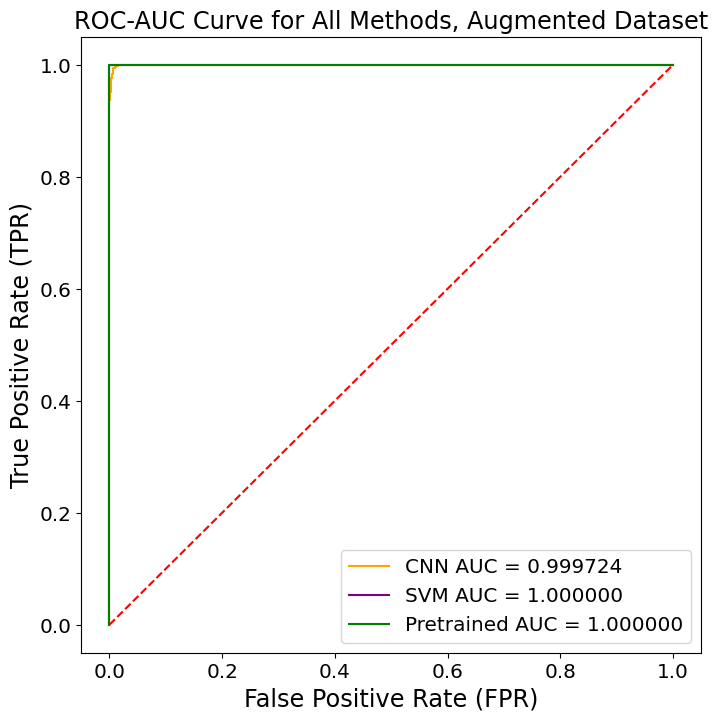

In [ ]:
get_auc_roc_curves(all_auc_roc)

## Heatmap

In [ ]:
def get_heatmap(all_heatmap):
  '''
  Heatmap to compare all methods on augmented data

  :@param all_heatmap (list): list of list of method names, accuracies and runtimes
  '''

  # organize data
  methods, runtimes, accuracies = [], [], []

  for k,t in all_heatmap.items():
    if t:
      methods += [k]
      accuracies += [t[0]]
      runtimes += [t[1]]

  # create dataframe of all data
  df = pd.DataFrame({'Method': methods, 'Runtime': runtimes,'Accuracy': accuracies})

  #plot
  fig, ax = plt.subplots()
  N = df.index.size

  # generate heatmap for each
  im1 = ax.imshow(np.vstack([df['Runtime'],df['Runtime']]).T, aspect='auto', extent=[-0.5,0.5,-0.5,N-0.5], origin='lower', cmap='viridis')
  im2 = ax.imshow(np.vstack([df['Accuracy'],df['Accuracy']]).T, aspect='auto', extent=[0.5,1.5,-0.5,N-0.5], origin='lower', cmap='viridis_r') # flipped so darker corresponds w/ higher acc

  # add color bars
  cax1 = fig.add_axes([1, 0.1, 0.03, 0.85])
  cbar1 = fig.colorbar(im1, cax=cax1, label='Test Runtime for 1 image (s)')
  cax2 = fig.add_axes([1.2, 0.1, 0.03, 0.85])
  cbar2 = fig.colorbar(im2, cax=cax2, label='Test Accuracy')

  ax.set_xlim(-0.5,1.5)
  ax.set_xticks([0,1])
  ax.set_xticklabels(['Runtime for 1 image (s)','Test Accuracy'])
  ax.set_yticks(range(N))
  ax.set_yticklabels(df['Method'])
  ax.set_ylabel('Method')
  fig.tight_layout()
  fig.suptitle('Accuracy vs Runtime on the Augmented Dataset', x=0.6, y=1, ha='center', va='center')
  plt.show()

<ipython-input-27-4ecc4b8bf20e>:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


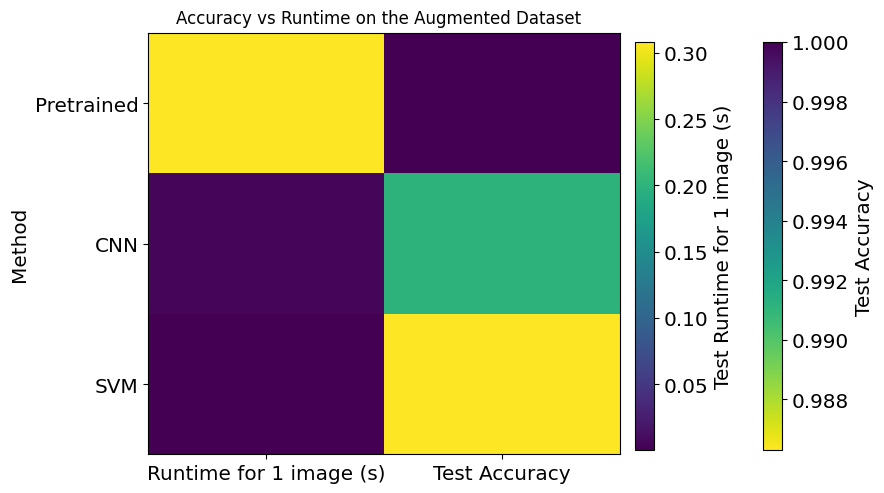

In [ ]:
get_heatmap(all_heatmap)